In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)


In [46]:
df = pd.read_csv(r"D:\ml lab\data\spambase.csv")

print(df.head())



   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_%3B  char_freq_%28  \
0             0.00            0.00  ...           0.00          0.0

In [47]:
print("Shape:", df.shape)


Shape: (4601, 58)


In [48]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [49]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class distribution:\n", y.value_counts())


X shape: (4601, 57)
y shape: (4601,)
Class distribution:
 class
0    2788
1    1813
Name: count, dtype: int64


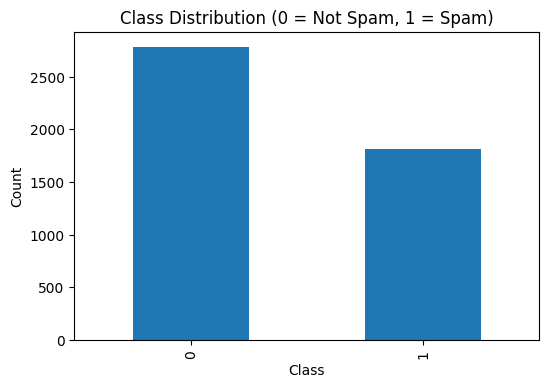

In [50]:
plt.figure(figsize=(6, 4))
y.value_counts().plot(kind="bar")
plt.title("Class Distribution (0 = Not Spam, 1 = Spam)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


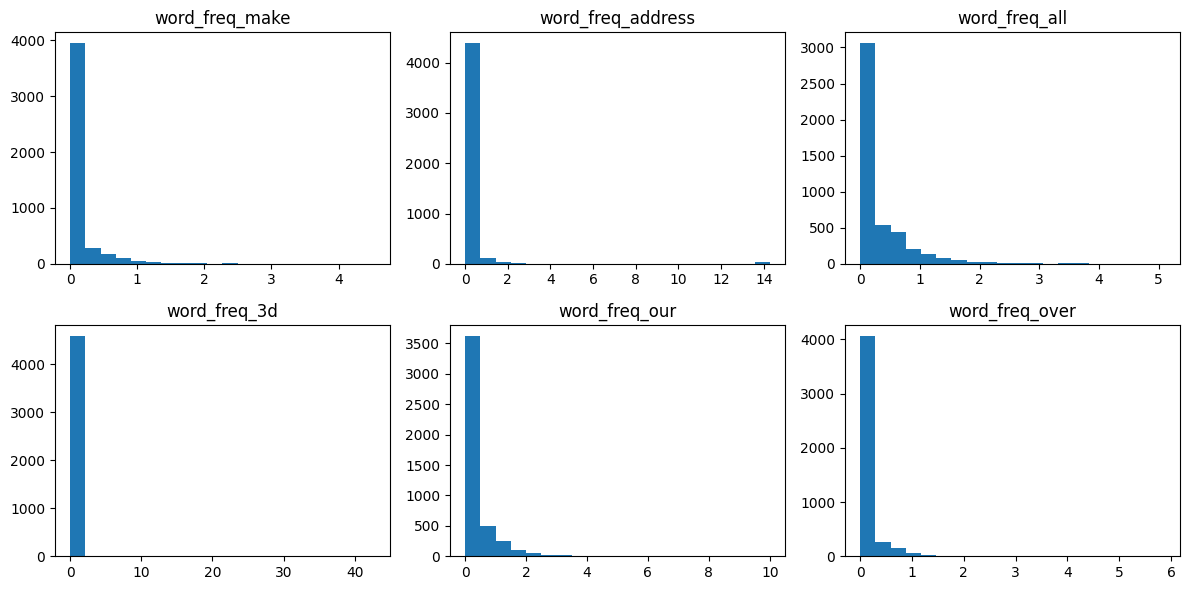

In [51]:
plt.figure(figsize=(12, 6))

for i, col in enumerate(X.columns[:6], 1):
    plt.subplot(2, 3, i)
    plt.hist(X[col], bins=20)
    plt.title(col)

plt.tight_layout()
plt.show()


In [56]:
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_clean = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_clean)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (3680, 57)
Test shape : (921, 57)


In [58]:
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

    return acc, prec, rec, f1, specificity, fpr, cm


def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start_pred

    acc, prec, rec, f1, spec, fpr, cm = compute_metrics(y_test, y_pred)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "specificity": spec,
        "fpr": fpr,
        "train_time": train_time,
        "pred_time": pred_time,
        "cm": cm,
        "y_pred": y_pred
    }


def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


def plot_roc_curve(model, X_test, y_test, title):
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    return roc_auc


Gaussian NB Results: {'accuracy': 0.8327904451682954, 'precision': 0.7145790554414785, 'recall': 0.9586776859504132, 'f1': 0.8188235294117647, 'specificity': np.float64(0.7508960573476703), 'fpr': np.float64(0.24910394265232974), 'train_time': 0.01887035369873047, 'pred_time': 0.004327058792114258, 'cm': array([[419, 139],
       [ 15, 348]]), 'y_pred': array([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,

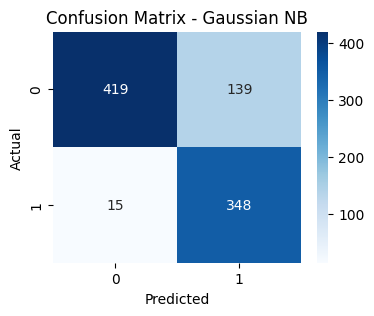

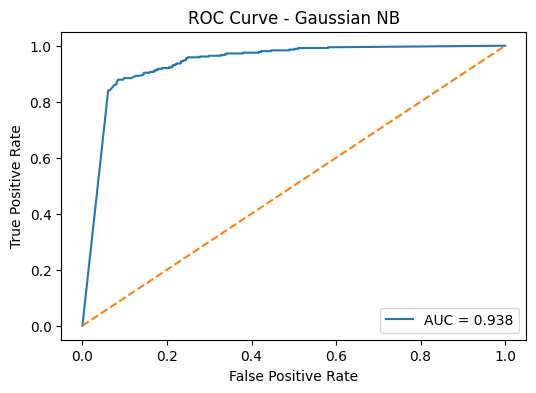

0.9376018246985989

In [59]:
gnb = GaussianNB()
gnb_result = train_and_evaluate(gnb, X_train, y_train, X_test, y_test)

print("Gaussian NB Results:", gnb_result)
plot_confusion_matrix(gnb_result["cm"], "Confusion Matrix - Gaussian NB")
plot_roc_curve(gnb, X_test, y_test, "ROC Curve - Gaussian NB")



Multinomial NB Results: {'accuracy': 0.8957654723127035, 'precision': 0.9348534201954397, 'recall': 0.790633608815427, 'f1': 0.8567164179104477, 'specificity': np.float64(0.96415770609319), 'fpr': np.float64(0.035842293906810034), 'train_time': 0.03331756591796875, 'pred_time': 0.0028738975524902344, 'cm': array([[538,  20],
       [ 76, 287]]), 'y_pred': array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 

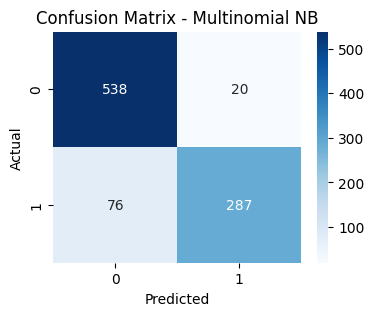

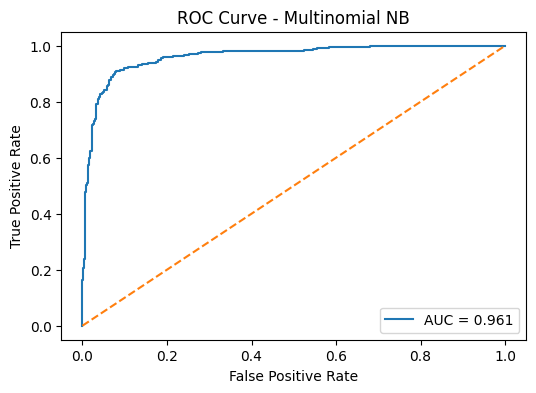

0.9611905960879568

In [60]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

mnb_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("minmax", MinMaxScaler()),
    ("mnb", MultinomialNB())
])

mnb_pipeline.fit(X_train_raw, y_train_raw)
y_pred_mnb = mnb_pipeline.predict(X_test_raw)

mnb_result = train_and_evaluate(mnb_pipeline, X_train_raw, y_train_raw, X_test_raw, y_test_raw)

print("Multinomial NB Results:", mnb_result)
plot_confusion_matrix(mnb_result["cm"], "Confusion Matrix - Multinomial NB")
plot_roc_curve(mnb_pipeline, X_test_raw, y_test_raw, "ROC Curve - Multinomial NB")


Bernoulli NB Results: {'accuracy': 0.8794788273615635, 'precision': 0.868421052631579, 'recall': 0.8181818181818182, 'f1': 0.8425531914893617, 'specificity': np.float64(0.9193548387096774), 'fpr': np.float64(0.08064516129032258), 'train_time': 0.059149742126464844, 'pred_time': 0.006165266036987305, 'cm': array([[513,  45],
       [ 66, 297]]), 'y_pred': array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0

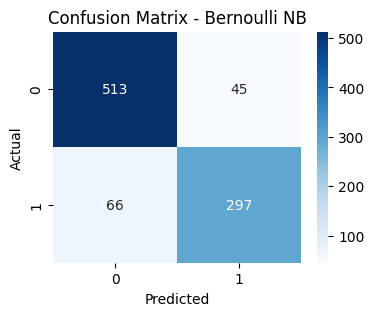

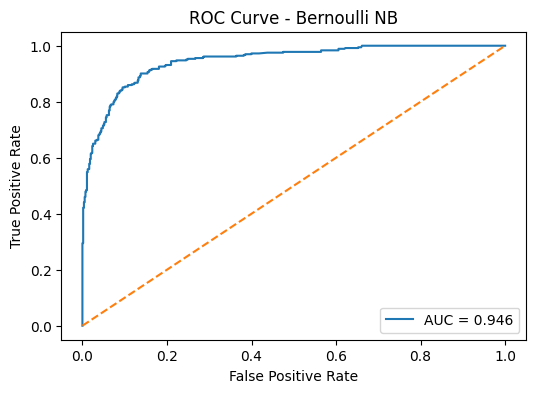

0.9456737462602566

In [61]:
bnb_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("minmax", MinMaxScaler()),
    ("bnb", BernoulliNB())
])

bnb_result = train_and_evaluate(bnb_pipeline, X_train_raw, y_train_raw, X_test_raw, y_test_raw)

print("Bernoulli NB Results:", bnb_result)
plot_confusion_matrix(bnb_result["cm"], "Confusion Matrix - Bernoulli NB")
plot_roc_curve(bnb_pipeline, X_test_raw, y_test_raw, "ROC Curve - Bernoulli NB")


Baseline KNN Results: {'accuracy': 0.9055374592833876, 'precision': 0.8876404494382022, 'recall': 0.8705234159779615, 'f1': 0.8789986091794159, 'specificity': np.float64(0.9283154121863799), 'fpr': np.float64(0.07168458781362007), 'train_time': 0.0024755001068115234, 'pred_time': 0.03839254379272461, 'cm': array([[518,  40],
       [ 47, 316]]), 'y_pred': array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 

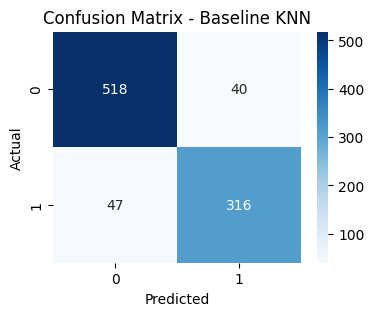

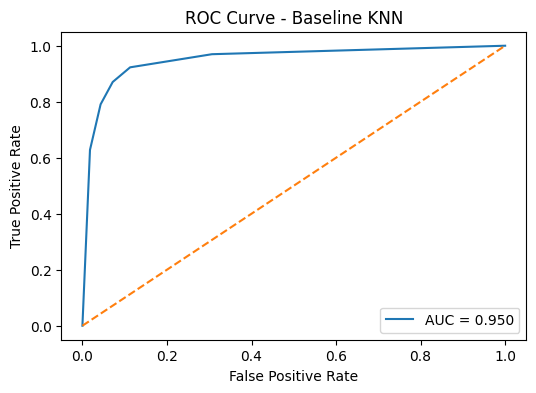

0.9503934753201616

In [62]:
knn_base = KNeighborsClassifier(n_neighbors=5)
knn_base_result = train_and_evaluate(knn_base, X_train, y_train, X_test, y_test)

print("Baseline KNN Results:", knn_base_result)
plot_confusion_matrix(knn_base_result["cm"], "Confusion Matrix - Baseline KNN")
plot_roc_curve(knn_base, X_test, y_test, "ROC Curve - Baseline KNN")


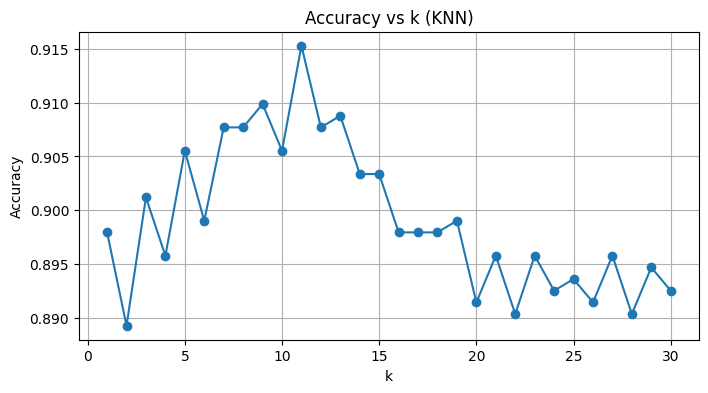

In [63]:
k_values = list(range(1, 31))
acc_values = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_values.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(8, 4))
plt.plot(k_values, acc_values, marker="o")
plt.title("Accuracy vs k (KNN)")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [64]:
param_grid = {
    "n_neighbors": list(range(1, 31)),
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # 1=Manhattan, 2=Euclidean
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("Grid Best Params:", grid.best_params_)
print("Grid Best CV Accuracy:", grid.best_score_)


Grid Best Params: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Grid Best CV Accuracy: 0.9247282608695653


In [65]:
random_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

random_search.fit(X_train, y_train)

print("Random Best Params:", random_search.best_params_)
print("Random Best CV Accuracy:", random_search.best_score_)


Random Best Params: {'weights': 'distance', 'p': 2, 'n_neighbors': 14}
Random Best CV Accuracy: 0.9209239130434783


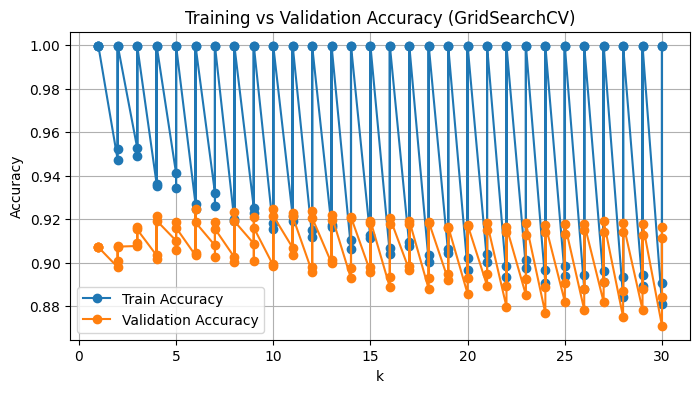

In [66]:
grid_df = pd.DataFrame(grid.cv_results_)

plt.figure(figsize=(8, 4))
plt.plot(grid_df["param_n_neighbors"], grid_df["mean_train_score"], marker="o", label="Train Accuracy")
plt.plot(grid_df["param_n_neighbors"], grid_df["mean_test_score"], marker="o", label="Validation Accuracy")
plt.title("Training vs Validation Accuracy (GridSearchCV)")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


KDTree KNN Results: {'accuracy': 0.9185667752442996, 'precision': 0.9390243902439024, 'recall': 0.8484848484848485, 'f1': 0.8914616497829233, 'specificity': np.float64(0.96415770609319), 'fpr': np.float64(0.035842293906810034), 'train_time': 0.054384469985961914, 'pred_time': 0.3548288345336914, 'cm': array([[538,  20],
       [ 55, 308]]), 'y_pred': array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,

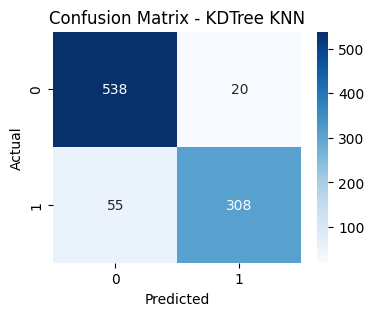

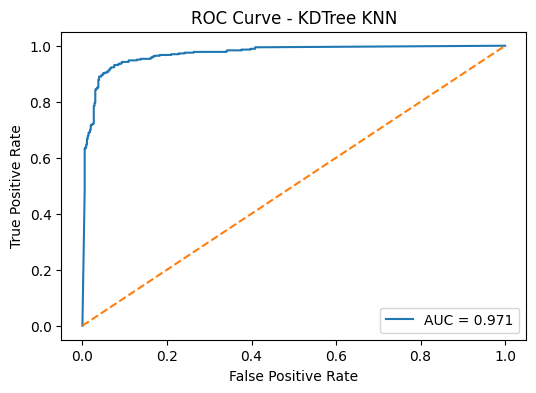

0.9714940213473938

In [67]:
best_k = grid.best_params_["n_neighbors"]
best_weights = grid.best_params_["weights"]
best_p = grid.best_params_["p"]

knn_kdtree = KNeighborsClassifier(
    n_neighbors=best_k,
    weights=best_weights,
    p=best_p,
    algorithm="kd_tree"
)

kdtree_result = train_and_evaluate(knn_kdtree, X_train, y_train, X_test, y_test)

print("KDTree KNN Results:", kdtree_result)
plot_confusion_matrix(kdtree_result["cm"], "Confusion Matrix - KDTree KNN")
plot_roc_curve(knn_kdtree, X_test, y_test, "ROC Curve - KDTree KNN")


BallTree KNN Results: {'accuracy': 0.9185667752442996, 'precision': 0.9390243902439024, 'recall': 0.8484848484848485, 'f1': 0.8914616497829233, 'specificity': np.float64(0.96415770609319), 'fpr': np.float64(0.035842293906810034), 'train_time': 0.03665781021118164, 'pred_time': 0.38995909690856934, 'cm': array([[538,  20],
       [ 55, 308]]), 'y_pred': array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 

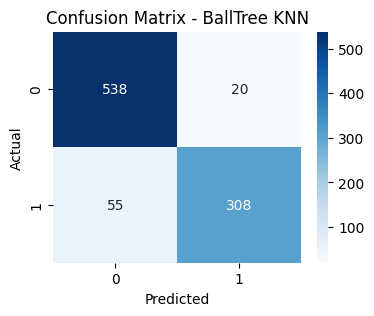

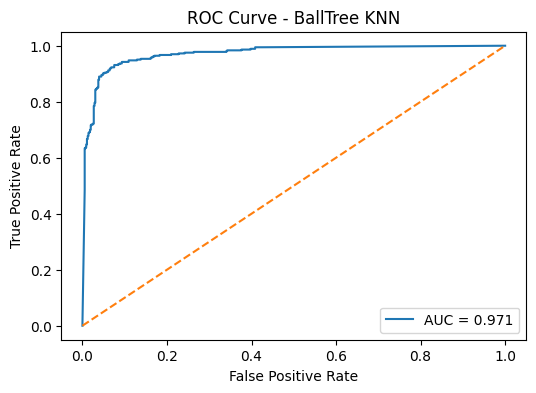

0.9714940213473938

In [68]:
knn_balltree = KNeighborsClassifier(
    n_neighbors=best_k,
    weights=best_weights,
    p=best_p,
    algorithm="ball_tree"
)

balltree_result = train_and_evaluate(knn_balltree, X_train, y_train, X_test, y_test)

print("BallTree KNN Results:", balltree_result)
plot_confusion_matrix(balltree_result["cm"], "Confusion Matrix - BallTree KNN")
plot_roc_curve(knn_balltree, X_test, y_test, "ROC Curve - BallTree KNN")


In [69]:
table1 = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "Specificity", "FPR", "Training Time (s)"],
    "Gaussian NB": [gnb_result["accuracy"], gnb_result["precision"], gnb_result["recall"],
                    gnb_result["f1"], gnb_result["specificity"], gnb_result["fpr"], gnb_result["train_time"]],
    "Multinomial NB": [mnb_result["accuracy"], mnb_result["precision"], mnb_result["recall"],
                       mnb_result["f1"], mnb_result["specificity"], mnb_result["fpr"], mnb_result["train_time"]],
    "Bernoulli NB": [bnb_result["accuracy"], bnb_result["precision"], bnb_result["recall"],
                     bnb_result["f1"], bnb_result["specificity"], bnb_result["fpr"], bnb_result["train_time"]],
})

print(table1)


              Metric  Gaussian NB  Multinomial NB  Bernoulli NB
0           Accuracy     0.832790        0.895765      0.879479
1          Precision     0.714579        0.934853      0.868421
2             Recall     0.958678        0.790634      0.818182
3           F1 Score     0.818824        0.856716      0.842553
4        Specificity     0.750896        0.964158      0.919355
5                FPR     0.249104        0.035842      0.080645
6  Training Time (s)     0.018870        0.033318      0.059150


In [70]:
table2 = pd.DataFrame([
    ["Grid Search", grid.best_params_["n_neighbors"], grid.best_score_, grid.best_params_],
    ["Randomized Search", random_search.best_params_["n_neighbors"], random_search.best_score_, random_search.best_params_]
], columns=["Search Method", "Best k", "Best CV Accuracy", "Best Parameters"])

print(table2)


       Search Method  Best k  Best CV Accuracy  \
0        Grid Search      10          0.924728   
1  Randomized Search      14          0.920924   

                                     Best Parameters  
0  {'n_neighbors': 10, 'p': 1, 'weights': 'distan...  
1  {'weights': 'distance', 'p': 2, 'n_neighbors':...  


In [71]:
table3 = pd.DataFrame([{
    "Optimal k": best_k,
    "Accuracy": kdtree_result["accuracy"],
    "Precision": kdtree_result["precision"],
    "Recall": kdtree_result["recall"],
    "F1 Score": kdtree_result["f1"],
    "Training Time (s)": kdtree_result["train_time"],
    "Prediction Time (s)": kdtree_result["pred_time"]
}])

table4 = pd.DataFrame([{
    "Optimal k": best_k,
    "Accuracy": balltree_result["accuracy"],
    "Precision": balltree_result["precision"],
    "Recall": balltree_result["recall"],
    "F1 Score": balltree_result["f1"],
    "Training Time (s)": balltree_result["train_time"],
    "Prediction Time (s)": balltree_result["pred_time"]
}])

print("Table 3: KDTree\n", table3)
print("\nTable 4: BallTree\n", table4)


Table 3: KDTree
    Optimal k  Accuracy  Precision    Recall  F1 Score  Training Time (s)  \
0         10  0.918567   0.939024  0.848485  0.891462           0.054384   

   Prediction Time (s)  
0             0.354829  

Table 4: BallTree
    Optimal k  Accuracy  Precision    Recall  F1 Score  Training Time (s)  \
0         10  0.918567   0.939024  0.848485  0.891462           0.036658   

   Prediction Time (s)  
0             0.389959  


In [72]:
table5 = pd.DataFrame([
    ["Accuracy", kdtree_result["accuracy"], balltree_result["accuracy"]],
    ["Training Time (s)", kdtree_result["train_time"], balltree_result["train_time"]],
    ["Prediction Time (s)", kdtree_result["pred_time"], balltree_result["pred_time"]],
    ["Memory Usage", "Low/Medium", "Medium/High"]
], columns=["Criterion", "KDTree", "BallTree"])

print(table5)


             Criterion      KDTree     BallTree
0             Accuracy    0.918567     0.918567
1    Training Time (s)    0.054384     0.036658
2  Prediction Time (s)    0.354829     0.389959
3         Memory Usage  Low/Medium  Medium/High
